### Business Growth Rate Forecasting

In [1]:
import pandas as pd
import numpy as np
# import matplotlib as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame, points_from_xy
import folium
import json
from urllib.request import urlopen
from cartoframes import read_carto, to_carto
from cartoframes.auth import set_default_credentials, Credentials
from cartoframes.viz import Map, Layer, basemaps
from cartoframes.data.clients import SQLClient
import requests
import io

PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
credentials = pd.read_csv('credentials.csv',header=0)
username = credentials.columns[0]
api_key = credentials.values[0][0]

set_default_credentials(username=username,api_key=api_key)

credentials = Credentials(username=username,api_key=api_key)

sql = SQLClient(credentials)

## Need to generate own Github personal access token
## to access csv files saved in US-Ignites repository
keyFile = open('Gitoken.txt', 'r')
token = keyFile.readline()
## Use own GitHub username (that has access to US-Igites Repo)
userFile = open('user.txt', 'r')
username = userFile.readline()

In [3]:
github_session = requests.Session()
github_session.auth = (username, token)

In [4]:
## Load Data Files (from csv)
## Can't upload industry data to Carto due
## to DB quota exceeded. Read via Git instead
url='https://raw.githubusercontent.com/us-ignite/UVA_Miami_Recovery_Tool/main/Data/ind.csv'
download = github_session.get(url).content
ind = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [5]:
## Load Data Files (from Carto)
## If encounter error transforming
## convert to Geoframe to Pandas DF
tran=read_carto('tran')
cols = tran.columns
tran[cols] = tran[cols].apply(pd.to_numeric, errors='coerce')
tran = tran.iloc[:,2:]

lfp=read_carto('lfp')
cols = lfp.columns
lfp[cols] = lfp[cols].apply(pd.to_numeric, errors='coerce')
lfp = lfp.iloc[:,2:]

ed=read_carto('ed')
cols = ed.columns
ed[cols] = ed[cols].apply(pd.to_numeric, errors='coerce')
ed = ed.iloc[:,2:]

maj=read_carto('maj')
cols = maj.columns
maj[cols] = maj[cols].apply(pd.to_numeric, errors='coerce')
maj = maj.iloc[:,2:]

net=read_carto('net')
cols = net.columns
net[cols] = net[cols].apply(pd.to_numeric, errors='coerce')
net = net.iloc[:,2:]

hom=read_carto('hom')
cols = hom.columns
hom[cols] = hom[cols].apply(pd.to_numeric, errors='coerce')
hom = hom.iloc[:,2:]

inc=read_carto('inc')
cols = inc.columns
inc[cols] = inc[cols].apply(pd.to_numeric, errors='coerce')
inc = inc.iloc[:,2:]

In [6]:
## Read in Chicago's ev_idx DF from carto
## and apply appropriate conversions
ev_idx=read_carto('ev_idx_zip')
ev_idx=ev_idx.iloc[:,2:]
cols = ev_idx.columns.drop('category')
ev_idx[cols] = ev_idx[cols].apply(pd.to_numeric, errors='coerce')
ev_idx.rename(columns={"zcta": "zip"}, inplace=True);

C:\Users\Alex\anaconda3\lib\site-packages\cartoframes\io\managers\context_manager.py:41: UserWarning: Read call rate limited. Waiting 3 seconds
  warn('Read call rate limited. Waiting {s} seconds'.format(s=err.retry_after))
C:\Users\Alex\anaconda3\lib\site-packages\cartoframes\io\managers\context_manager.py:43: UserWarning: Retrying...
  warn('Retrying...')


In [7]:
ind = ind[(ind.empszes==1) & ind['ind'].str.contains('Total')]
ind = ind[(ind['ind']=='Total') | (ind['ind']=='Total for all sectors')]
ind = ind[['estab','emp','payroll','zip','year']]
ind['estab'] = pd.to_numeric(ind['estab'])

In [8]:
ind.set_index(['year','zip'], inplace=True)

In [9]:
## Set multiindex for all DFs
tran.set_index(['year','zip'], inplace=True)
lfp.set_index(['year','zip'], inplace=True)
ed.set_index(['year','zip'], inplace=True)
maj.set_index(['year','zip'], inplace=True)
net.set_index(['year','zip'], inplace=True)
hom.set_index(['year','zip'], inplace=True)
inc.set_index(['year','zip'], inplace=True)
ev_idx.set_index(['year','zip'], inplace=True)

In [10]:
df = tran.merge(lfp, left_index=True, right_index=True)
df = df.merge(ed, left_index=True, right_index=True)
df = df.merge(hom, left_index=True, right_index=True)
df = df.merge(inc, left_index=True, right_index=True)
df = df.merge(maj, left_index=True, right_index=True, how='outer')
df = df.merge(net, left_index=True, right_index=True, how='outer')
## ev_idx doesn't have data for all 80 zip codes
df = df.merge(ev_idx, left_index=True, right_index=True, how='outer')

In [11]:
full = ind.merge(df, left_index=True, right_index=True)
full["estab"] = pd.to_numeric(full["estab"])
full.sort_index(inplace=True)

In [12]:
pd.set_option('display.max_columns', 100)
full.corr()

,estab,emp_x,payroll,total,drove,carpool,publictrans,taxi,motorbike,bike,walk,other,wfh,pop,labforce,civlf,emp_y,unemp,military,notinlf,part_rate,civ_rate,tot,bach,bachlf,bachmil,bachciv,bachemp,bachunemp,bachnotinlf,per_bachlf,per_bachciv,medval,medyear,tot_units,occup,vacant,own_occ,own_std,rent_occ,rent_std,substd,inc2pov,housinc,medhousinc,agghousinc,gini,faminc,medfaminc,incpercap,meanhousinc,popdens,tot_bach,pc_math_stat,bio_ag_es,phys_rel_sci,psych,social_sci,eng,multi_sci,relat_fields,biz,educ,lit_lang,lib_hist,viz_perf,comm,other_art_hum,sci_eng,arts_hum,households,device,pc,internet,per_pc,per_int,int_nocell,per_int_nocell,percent_unemployed,portion_below_poverty,ea_portion_lt_college,portion_ind_not_infofinprof,ev_idx
estab,1.000000,0.884464,0.799088,0.451455,0.420279,0.218032,0.096885,0.165525,0.197994,0.254829,0.397204,0.166676,0.488119,0.403802,0.431374,0.431481,0.450090,0.136738,0.077495,0.333666,0.216501,0.219339,0.403802,0.659898,0.652801,0.074421,0.653058,0.652824,0.472456,0.640365,0.401292,0.402200,0.119853,0.086596,0.541871,0.516207,0.345595,0.409557,0.446266,0.438653,0.536392,0.427378,0.398200,0.516207,0.088687,0.600394,0.101989,0.398200,0.151228,0.093859,0.009283,0.289295,0.668244,0.622066,0.603180,0.596315,0.611567,0.668111,0.542611,0.445943,0.513113,0.659306,0.464260,0.583581,0.565102,0.531936,0.659291,0.456657,0.665545,0.632574,0.520087,0.550067,0.584740,0.572861,0.159077,0.090271,0.574514,0.094993,-0.263339,-0.235495,-0.328322,-0.314500,-0.342854
emp_x,0.884464,1.000000,0.910807,0.334008,0.297028,0.132039,0.111146,0.179752,0.181643,0.275524,0.403810,0.105557,0.377788,0.294854,0.320551,0.320560,0.332589,0.116462,0.073137,0.234601,0.172627,0.174252,0.294854,0.509127,0.498218,0.098548,0.498203,0.499212,0.337451,0.523812,0.318196,0.318637,0.037013,0.023505,0.431680,0.399855,0.299893,0.233356,0.261716,0.427341,0.507256,0.351651,0.282964,0.399855,0.017426,0.435738,0.046543,0.282964,0.075835,0.037923,-0.030430,0.234394,0.498814,0.509375,0.456133,0.435753,0.435437,0.504385,0.436768,0.380850,0.349302,0.521224,0.275563,0.425640,0.412555,0.381757,0.511071,0.323658,0.501121,0.465611,0.399874,0.408609,0.428868,0.415757,0.069946,0.004217,0.421591,0.032632,-0.151853,-0.115665,-0.240829,-0.220511,-0.221202
payroll,0.799088,0.910807,1.000000,0.187593,0.159899,0.016955,0.052520,0.126270,0.131515,0.149899,0.362929,0.041720,0.266277,0.137537,0.169783,0.169740,0.186186,-0.021765,0.049213,0.076514,0.230356,0.231121,0.137537,0.442409,0.432493,0.092654,0.432444,0.436729,0.226908,0.457561,0.433087,0.433438,0.028107,0.017890,0.289582,0.242106,0.257594,0.094394,0.130054,0.307702,0.409486,0.192981,0.131487,0.242106,0.013468,0.351206,0.035405,0.131487,0.056314,0.029014,0.039466,0.386243,0.433060,0.436165,0.414461,0.349163,0.355992,0.496196,0.385309,0.349512,0.256427,0.488787,0.141397,0.355738,0.363845,0.339553,0.491275,0.261097,0.435380,0.411954,0.253433,0.272040,0.303199,0.285396,0.127346,0.057253,0.289462,0.060204,-0.191503,-0.124016,-0.312269,-0.331578,-0.287202
total,0.451455,0.334008,0.187593,1.000000,0.978815,0.849628,0.376638,0.241552,0.152801,0.172168,0.197295,0.457796,0.572921,0.978216,0.995857,0.995868,0.999903,0.637822,0.230468,0.888178,0.208953,0.212257,0.978216,0.713207,0.721891,0.116959,0.722000,0.713042,0.690705,0.602518,-0.081005,-0.080290,0.336246,0.260950,0.811410,0.944794,0.146477,0.887600,0.869052,0.658804,0.620038,0.884346,0.974057,0.944794,0.279020,0.688517,0.260957,0.974057,0.359298,0.252819,-0.282314,0.189207,0.695364,0.610753,0.554420,0.612152,0.587430,0.448597,0.650264,0.352017,0.801874,0.590945,0.830751,0.406218,0.441071,0.419545,0.427958,0.762337,0.706807,0.552841,0.943068,0.947551,0.939838,0.943816,-0.079989,-0.129126,0.926489,-0.140954,-0.134713,-0.056660,0.046419,0.141366,-0.011391
drove,0.420279,0.297028,0.159899,0.978815,1.000000,0.810855,0.244121,0.125525,0.011724,0.021852,0.038773,0.389706,0.505250,0.958597,0.973073,0.973252,0.978292,0.614257,0.188367,0.874932,0.181579,0.185288,0.958597,0.690495

### PanelOLS Fixed & Time Effects Model

In [13]:
mod = full[['estab','labforce','inc2pov','housinc','medhousinc','agghousinc','meanhousinc','gini',
             'medval','portion_ind_not_infofinprof','incpercap','popdens','ea_portion_lt_college']]

In [14]:
## 33101 only contains govt offices, garage & school
## 33122 Miami International Airport
## 33039 Homestead Air Force Base
mod = mod.drop([33039, 33101, 33122], level=1)

In [15]:
len(mod.reset_index()['zip'].unique())

77

In [16]:
mod.describe()

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college
count,693.000000,693.000000,693.000000,693.000000,693.000000,6.930000e+02,693.000000,693.000000,6.920000e+02,693.000000,693.000000,693.000000,693.000000
mean,1037.930736,17300.059163,7521.640693,10995.248196,54173.063492,7.674401e+08,78551.660273,0.470710,-1.644242e+06,0.768406,29466.875902,7391.974457,0.438647
std,844.106124,8697.950312,3906.431940,5344.421390,30463.352003,4.637263e+08,58414.201379,0.063462,3.583008e+07,0.078768,27595.077808,5772.718986,0.175230
min,27.000000,80.000000,69.000000,69.000000,18920.000000,5.496670e+07,28059.111842,0.287600,-6.666667e+08,0.359756,6763.000000,77.835400,0.050154
25%,405.000000,10525.000000,4103.000000,6701.000000,37167.000000,4.253758e+08,50023.630052,0.427500,1.697000e+05,0.730224,16611.000000,3937.974684,0.310671
50%,802.000000,16774.000000,7359.000000,11367.000000,48456.000000,6.732357e+08,64812.020183,0.459800,2.320000e+05,0.787867,22127.000000,6773.114754,0.453826
75%,1431.000000,24166.000000,10425.000000,14623.000000,63428.000000,1.001548e+09,88746.004152,0.510500,3.218000e+05,0.823617,31526.000000,9375.882353,0.569354
max,4195.000000,40240.000000,17711.000000,24396.000000,250001.000000,2.297641e+09,796618.840580,0.633100,2.000001e+06,0.914068,376207.000000,46192.500000,0.825306


In [17]:
## Detrend data by converting to annual growth rates
pct_df = mod.groupby(level=[1]).pct_change(1)

In [18]:
mod.xs(33193, level=1)

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college
year,,,,,,,,,,,,,
2011,322,24131,10635,13215,49468.0,8.401185e+08,63573.098751,0.4328,238400.0,0.813090,20290.0,5552.222222,0.445026
2012,336,23878,10556,13079,48032.0,7.826283e+08,59838.542702,0.4192,221200.0,0.832210,19507.0,5453.703704,0.430028
2013,372,24492,10943,13282,50329.0,8.224464e+08,61921.879235,0.4135,204200.0,0.839547,19961.0,5660.740741,0.434681
2014,380,25526,11147,13444,49945.0,8.361080e+08,62191.907170,0.4194,198300.0,0.829945,19696.0,5959.629630,0.440182
2015,405,26569,11618,13827,50838.0,8.793705e+08,63598.068995,0.4190,202500.0,0.819417,19949.0,6253.456790,0.418904
2016,430,26837,12006,14139,50396.0,9.064449e+08,64109.548059,0.4157,217600.0,0.802361,20577.0,6180.617284,0.408013
2017,431,27010,12417,14383,54132.0,9.840259e+08,68415.900716,0.4155,230500.0,0.798542,21690.0,6347.777778,0.398125
2018,462,27209,12226,14402,58004.0,1.018722e+09,70734.745174,0.4185,260100.0,0.793475,22525.0,6342.962963,0.399811
2019,495,27119,12099,14427,63337.0,1.076863e+09,74642.170930,0.4138,293600.0,0.800193,24118.0,6172.716049,0.405003


In [19]:
pct_df.xs(33193, level=1)

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college
year,,,,,,,,,,,,,
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,0.043478,-0.010484,-0.007428,-0.010291,-0.029029,-0.068431,-0.058744,-0.031423,-0.072148,0.023516,-0.038590,-0.017744,-0.033702
2013,0.107143,0.025714,0.036662,0.015521,0.047822,0.050877,0.034816,-0.013597,-0.076854,0.008816,0.023274,0.037963,0.010821
2014,0.021505,0.042218,0.018642,0.012197,-0.007630,0.016611,0.004361,0.014268,-0.028893,-0.011437,-0.013276,0.052800,0.012654
2015,0.065789,0.040860,0.042254,0.028489,0.017880,0.051743,0.022610,-0.000954,0.021180,-0.012685,0.012845,0.049303,-0.048339
2016,0.061728,0.010087,0.033396,0.022565,-0.008694,0.030788,0.008042,-0.007876,0.074568,-0.020815,0.031480,-0.011648,-0.025999
2017,0.002326,0.006446,0.034233,0.017257,0.074133,0.085588,0.067172,-0.000481,0.059283,-0.004761,0.054090,0.027046,-0.024233
2018,0.071926,0.007368,-0.015382,0.001321,0.071529,0.035259,0.033893,0.007220,0.128416,-0.006345,0.038497,-0.000759,0.004234
2019,0.071429,-0.003308,-0.010388,0.001736,0.091942,0.057072,0.055241,-0.011231,0.128797,0.008466,0.070721,-0.026840,0.012985


In [20]:
mod = pct_df.copy()
## Remove 2011, since growth rates NaN
mod = mod.loc[2012:]

In [21]:
## See what zip codes still have NaN values & remove them
mod[mod.isnull().values].index.unique(level=1)

Int64Index([], dtype='int64', name='zip')

In [22]:
## Create Lagged Variables
df = mod.copy()
# df = df.drop(columns=['payroll'])
df_lag = df.unstack().shift(1)
df_lag = df_lag.stack(dropna=False)
df_lag = df_lag.add_suffix('_lag')
df_lag2 = df_lag.unstack().shift(1)
df_lag2 = df_lag2.stack(dropna=False)
df_lag2 = df_lag2.add_suffix('2')
## Create difference of lag variables
df_diff = df_lag - df_lag2.values
df_diff = df_diff.add_suffix('Diff')
## Merge
df_lag = df_lag.merge(df_lag2, left_index=True, right_index=True)
df_lag = df_lag.merge(df_diff, left_index=True, right_index=True)
df = df.merge(df_lag, left_index=True, right_index=True)

In [23]:
df.xs(33193, level=1)

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college,estab_lag,labforce_lag,inc2pov_lag,housinc_lag,medhousinc_lag,agghousinc_lag,meanhousinc_lag,gini_lag,medval_lag,portion_ind_not_infofinprof_lag,incpercap_lag,popdens_lag,ea_portion_lt_college_lag,estab_lag2,labforce_lag2,inc2pov_lag2,housinc_lag2,medhousinc_lag2,agghousinc_lag2,meanhousinc_lag2,gini_lag2,medval_lag2,portion_ind_not_infofinprof_lag2,incpercap_lag2,popdens_lag2,ea_portion_lt_college_lag2,estab_lagDiff,labforce_lagDiff,inc2pov_lagDiff,housinc_lagDiff,medhousinc_lagDiff,agghousinc_lagDiff,meanhousinc_lagDiff,gini_lagDiff,medval_lagDiff,portion_ind_not_infofinprof_lagDiff,incpercap_lagDiff,popdens_lagDiff,ea_portion_lt_college_lagDiff
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,0.043478,-0.010484,-0.007428,-0.010291,-0.029029,-0.068431,-0.058744,-0.031423,-0.072148,0.023516,-0.038590,-0.017744,-0.033702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,0.107143,0.025714,0.036662,0.015521,0.047822,0.050877,0.034816,-0.013597,-0.076854,0.008816,0.023274,0.037963,0.010821,0.043478,-0.010484,-0.007428,-0.010291,-0.029029,-0.068431,-0.058744,-0.031423,-0.072148,0.023516,-0.038590,-0.017744,-0.033702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,0.021505,0.042218,0.018642,0.012197,-0.007630,0.016611,0.004361,0.014268,-0.028893,-0.011437,-0.013276,0.052800,0.012654,0.107143,0.025714,0.036662,0.015521,0.047822,0.050877,0.034816,-0.013597,-0.076854,0.008816,0.023274,0.037963,0.010821,0.043478,-0.010484,-0.007428,-0.010291,-0.029029,-0.068431,-0.058744,-0.031423,-0.072148,0.023516,-0.038590,-0.017744,-0.033702,0.063665,0.036198,0.044090,0.025812,0.076851,0.119308,0.093560,0.017826,-0.004706,-0.014700,0.061864,0.055707,0.044523
2015,0.065789,0.040860,0.042254,0.028489,0.017880,0.051743,0.022610,-0.000954,0.021180,-0.012685,0.012845,0.049303,-0.048339,0.021505,0.042218,0.018642,0.012197,-0.007630,0.016611,0.004361,0.014268,-0.028893,-0.011437,-0.013276,0.052800,0.012654,0.107143,0.025714,0.036662,0.015521,0.047822,0.050877,0.034816,-0.013597,-0.076854,0.008816,0.023274,0.037963,0.010821,-0.085637,0.016504,-0.018020,-0.003324,-0.055452,-0.034266,-0.030455,0.027866,0.047960,-0.020252,-0.036550,0.014838,0.001833
2016,0.061728,0.010087,0.033396,0.022565,-0.008694,0.030788,0.008042,-0.007876,0.074568,-0.020815,0.031480,-0.011648,-0.025999,0.065789,0.040860,0.042254,0.028489,0.017880,0.051743,0.022610,-0.000954,0.021180,-0.012685,0.012845,0.049303,-0.048339,0.021505,0.042218,0.018642,0.012197,-0.007630,0.016611,0.004361,0.014268,-0.028893,-0.011437,-0.013276,0.052800,0.012654,0.044284,-0.001358,0.023611,0.016292,0.025509,0.035132,0.018249,-0.015222,0.050073,-0.001249,0.026121,-0.003497,-0.060993
2017,0.002326,0.006446,0.034233,0.017257,0.074133,0.085588,0.067172,-0.000481,0.059283,-0.004761,0.054090,0.027046,-0.024233,0.061728,0.010087,0.033396,0.022565,-0.008694,0.030788,0.008042,-0.007876,0.074568,-0.020815,0.031480,-0.011648,-0.025999,0.065789,0.040860,0.042254,0.028489,0.017880,0.051743,0.022610,-0.000954,0.021180,-0.012685,0.012845,0.049303,-0.048339,-0.004061,-0.030773,-0.008857,-0.005924,-0.026574,-0.020954,-0.014568,-0.006922,0.053388,-0.008129,0.018635,-0.060951,0.022340
2018,0.071926,0.007368,-0.015382,0.001321,0.071529,0.035259,0.033893,0.007220,0.128416,-0.006345,0.038497,-0.000759,0.004234,0.002326,0.006446,0.034233,0.017257,0.074133,0.085588,0.067172,-0.000481,0.059283,-0.004761,0.054090,0.027046,-0.024233,0.061728,0.010087,0.033396,0.022565,-0.008694,0.030788,0.008042,-0.007876,0.074568,-0.020815,0.031480,-0.011648,-0.025999,-0.059403,-0.003641,0.000836,-0.005307,0.082827,0.054800,0.059129,0.007395,-0.015285,0.016054,0.022609,0.038694,0.001766
2019,0.071429,-0.003308,-0.010388,0.001736

In [24]:
## Entities have to come before time period
## for PanelOLS to run properly
df = df.reset_index().set_index(['zip','year'])
df.head()

,,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college,estab_lag,labforce_lag,inc2pov_lag,housinc_lag,medhousinc_lag,agghousinc_lag,meanhousinc_lag,gini_lag,medval_lag,portion_ind_not_infofinprof_lag,incpercap_lag,popdens_lag,ea_portion_lt_college_lag,estab_lag2,labforce_lag2,inc2pov_lag2,housinc_lag2,medhousinc_lag2,agghousinc_lag2,meanhousinc_lag2,gini_lag2,medval_lag2,portion_ind_not_infofinprof_lag2,incpercap_lag2,popdens_lag2,ea_portion_lt_college_lag2,estab_lagDiff,labforce_lagDiff,inc2pov_lagDiff,housinc_lagDiff,medhousinc_lagDiff,agghousinc_lagDiff,meanhousinc_lagDiff,gini_lagDiff,medval_lagDiff,portion_ind_not_infofinprof_lagDiff,incpercap_lagDiff,popdens_lagDiff,ea_portion_lt_college_lagDiff
zip,year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33010,2012,0.021780,0.025611,-0.006772,-0.019986,-0.056531,-0.040885,-0.021325,0.019760,-0.121929,0.002443,-0.023804,0.005757,0.007892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33012,2012,0.024899,0.022307,-0.021060,-0.020790,0.016399,-0.025539,-0.004849,-0.018304,-0.101765,0.009121,-0.007132,0.011898,0.005565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33013,2012,0.000000,-0.042409,-0.014599,-0.009001,-0.039840,-0.057926,-0.049370,0.013468,-0.115006,-0.008511,-0.027398,-0.010473,-0.005001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33014,2012,0.020733,0.032184,-0.006454,-0.015901,-0.000487,-0.005833,0.010230,0.022638,-0.058848,0.002938,-0.014626,0.025296,0.023473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33015,2012,0.031877,0.025798,0.043795,0.038646,-0.029671,0.001122,-0.036128,-0.006771,-0.140212,-0.009912,-0.040880,0.051023,-0.057477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.describe()

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college,estab_lag,labforce_lag,inc2pov_lag,housinc_lag,medhousinc_lag,agghousinc_lag,meanhousinc_lag,gini_lag,medval_lag,portion_ind_not_infofinprof_lag,incpercap_lag,popdens_lag,ea_portion_lt_college_lag,estab_lag2,labforce_lag2,inc2pov_lag2,housinc_lag2,medhousinc_lag2,agghousinc_lag2,meanhousinc_lag2,gini_lag2,medval_lag2,portion_ind_not_infofinprof_lag2,incpercap_lag2,popdens_lag2,ea_portion_lt_college_lag2,estab_lagDiff,labforce_lagDiff,inc2pov_lagDiff,housinc_lagDiff,medhousinc_lagDiff,agghousinc_lagDiff,meanhousinc_lagDiff,gini_lagDiff,medval_lagDiff,portion_ind_not_infofinprof_lagDiff,incpercap_lagDiff,popdens_lagDiff,ea_portion_lt_college_lagDiff
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,0.024812,0.018053,0.013841,0.013467,0.022426,0.036754,0.024219,0.004023,-12.300746,-0.002362,0.025312,0.016850,-0.020934,0.026229,0.021038,0.012793,0.013774,0.017944,0.033289,0.020767,0.005000,-14.072085,-0.002176,0.021918,0.020052,-0.022921,0.027096,0.021418,0.011315,0.013259,0.011910,0.027572,0.015932,0.006707,-16.432164,-0.002662,0.016774,0.021743,-0.024983,-0.003627,-0.004320,0.000473,-0.001627,0.010973,0.010277,0.009927,-0.002808,0.033119,-0.000341,0.010999,-0.006643,-0.005564
std,0.039725,0.084982,0.056139,0.072975,0.060969,0.065266,0.054090,0.033064,280.219817,0.034480,0.058328,0.096823,0.130418,0.040138,0.088573,0.057522,0.076439,0.059922,0.063671,0.054478,0.033528,299.560412,0.036065,0.058586,0.102150,0.135712,0.039490,0.094036,0.060291,0.081566,0.060018,0.062711,0.054598,0.033092,323.551973,0.035981,0.059668,0.109418,0.142543,0.049091,0.105430,0.071169,0.076780,0.086750,0.077128,0.066308,0.048372,458.127277,0.054791,0.067190,0.113027,0.173130
min,-0.200000,-0.385768,-0.150494,-0.230769,-0.332099,-0.341094,-0.537809,-0.190315,-6923.810654,-0.486338,-0.631844,-0.322327,-0.655967,-0.200000,-0.385768,-0.150494,-0.112683,-0.332099,-0.166468,-0.537809,-0.190315,-6923.810654,-0.486338,-0.631844,-0.322327,-0.655967,-0.180556,-0.385768,-0.150494,-0.112683,-0.332099,-0.166468,-0.537809,-0.140842,-6923.810654,-0.486338,-0.631844,-0.322327,-0.655967,-0.287121,-1.665367,-1.030212,-1.415432,-0.497227,-0.297116,-0.200002,-0.269827,-6923.830781,-0.447896,-0.222486,-2.159391,-2.531178
25%,0.003317,-0.011309,-0.012662,-0.008106,-0.011001,-0.002347,-0.006073,-0.013587,-0.054687,-0.012998,-0.005736,-0.006718,-0.049860,0.005561,-0.006571,-0.013098,-0.008967,-0.015616,-0.005563,-0.008182,-0.011783,-0.067797,-0.012591,-0.009906,-0.004296,-0.050745,0.006108,-0.006137,-0.014201,-0.009756,-0.022134,-0.010757,-0.011601,-0.009691,-0.077530,-0.012331,-0.013829,-0.001557,-0.052107,-0.023249,-0.034549,-0.020906,-0.015142,-0.031010,-0.030607,-0.025207,-0.027017,-0.000694,-0.014652,-0.022360,-0.025715,-0.055882
50%,0.020472,0.012547,0.009983,0.008715,0.021074,0.033895,0.024582,0.004814,0.041994,-0.002656,0.026571,0.010883,-0.016978,0.022026,0.015012,0.008187,0.007991,0.017291,0.029801,0.020174,0.005666,0.029863,-0.002689,0.022629,0.013294,-0.017618,0.022983,0.015170,0.006231,0.007407,0.010050,0.022603,0.013806,0.007068,0.009945,-0.002509,0.016074,0.013924,-0.018524,-0.002520,-0.001545,0.003238,0.001287,0.010091,0.011987,0.009507,-0.001976,0.033514,0.000538,0.009773,-0.001982,-0.001775
75%,0.042362,0.039786,0.031310,0.025889,0.055644,0.067763,0.052010,0.020317,0.094898,0.008813,0.053806,0.030

In [26]:
df.corr().sort_values(by='estab', ascending=False)

,estab,labforce,inc2pov,housinc,medhousinc,agghousinc,meanhousinc,gini,medval,portion_ind_not_infofinprof,incpercap,popdens,ea_portion_lt_college,estab_lag,labforce_lag,inc2pov_lag,housinc_lag,medhousinc_lag,agghousinc_lag,meanhousinc_lag,gini_lag,medval_lag,portion_ind_not_infofinprof_lag,incpercap_lag,popdens_lag,ea_portion_lt_college_lag,estab_lag2,labforce_lag2,inc2pov_lag2,housinc_lag2,medhousinc_lag2,agghousinc_lag2,meanhousinc_lag2,gini_lag2,medval_lag2,portion_ind_not_infofinprof_lag2,incpercap_lag2,popdens_lag2,ea_portion_lt_college_lag2,estab_lagDiff,labforce_lagDiff,inc2pov_lagDiff,housinc_lagDiff,medhousinc_lagDiff,agghousinc_lagDiff,meanhousinc_lagDiff,gini_lagDiff,medval_lagDiff,portion_ind_not_infofinprof_lagDiff,incpercap_lagDiff,popdens_lagDiff,ea_portion_lt_college_lagDiff
estab,1.000000,0.219765,0.090409,0.190500,-0.180718,-0.111005,-0.253232,-0.066746,0.083809,0.036379,-0.265936,0.219229,0.157301,0.157109,0.353813,0.277697,0.276474,0.094945,0.156531,-0.063312,-0.017728,0.039283,0.327713,-0.186480,0.327531,0.249097,0.153677,-0.098502,-0.021982,-0.091309,0.052715,-0.068282,-0.036131,-0.189983,0.104745,-0.052619,-0.004094,-0.093667,-0.122832,-0.047375,0.244413,0.111753,0.166186,0.042354,0.143223,0.046940,0.100907,-0.043644,0.221995,-0.093713,0.208664,0.173851
labforce_lag,0.353813,0.024346,-0.092287,0.201362,-0.257794,-0.093571,-0.230650,-0.080819,0.006409,-0.214682,-0.159659,0.042053,-0.063503,0.234012,1.000000,0.768564,0.907411,0.104200,0.355798,-0.301652,-0.125119,0.051405,0.464351,-0.405671,0.935650,0.721464,-0.094610,0.009247,0.099918,0.082950,0.135590,0.157612,0.071130,0.161598,0.013113,0.076921,0.134267,0.035649,0.012498,0.164465,0.452247,0.196923,0.177945,0.047903,0.227681,0.035348,-0.282832,0.059398,0.108387,-0.153766,0.227413,0.094186
portion_ind_not_infofinprof_lag,0.327713,0.024708,-0.175767,0.017724,-0.254906,-0.171906,-0.224936,0.026609,0.007169,-0.212448,-0.198375,-0.032710,0.017063,0.052939,0.464351,0.244061,0.410861,0.200554,0.167456,-0.102763,-0.012853,0.044463,1.000000,-0.257475,0.481000,0.544360,-0.074168,-0.218791,-0.178624,-0.147532,-0.171914,-0.200581,-0.097913,0.036823,0.008797,-0.211437,0.017043,-0.178323,-0.201258,0.031167,0.311669,0.130919,0.203379,0.301044,0.296679,0.174818,-0.037954,0.028492,0.766826,-0.070007,0.277871,0.361482
popdens_lag,0.327531,0.043392,-0.129424,0.222646,-0.300318,-0.104290,-0.257644,-0.059204,0.019465,-0.178456,-0.189605,0.076141,-0.046934,0.232780,0.935650,0.787071,0.945471,0.048284,0.271003,-0.386689,-0.049535,0.010054,0.481000,-0.509263,1.000000,0.787487,-0.009151,0.032565,0.096044,0.096373,0.013153,0.084931,-0.018664,0.139725,0.012940,0.020353,0.008644,0.072354,0.035362,0.076615,0.336096,0.257395,0.184386,0.110622,0.269039,0.064002,-0.204346,0.007097,0.186709,-0.171441,0.260277,0.085391
inc2pov_lag,0.277697,0.089188,0.069989,0.239121,-0.214712,-0.015715,-0.168490,-0.103603,0.014354,-0.181586,-0.123401,0.082860,-0.030154,0.111250,0.768564,1.000000,0.810086,0.172297,0.474715,-0.156043,-0.102224,-0.044858,0.244061,-0.232496,0.787071,0.504099,0.016368,-0.111851,0.055647,-0.053583,0.029877,0.205097,0.176241,0.108844,-0.032408,-0.192152,0.259575,-0.143700,-0.205258,-0.043832,0.323096,0.533431,0.311982,0.145313,0.221115,-0.011174,-0.193098,-0.025645,0.104117,-0.150790,0.331852,0.148143
housinc_lag,0.276474,0.084102,-0.033070,0.308016,-0.203567,0.024098,-0.156935,-0.081476,-0.007003,-0.146288,-0.073412,0.095263,-0.034509,0.221810,0.907411,0.810086,1.000000,0.029070,0.372946,-0.369981,-0.036585,-0.025840,0.410861,-0.369058,0.945471,0.713397,0.063601,0.234813,0.295698,0.342115,0.108136,0.296262,-0.005539,0.095174,-0.002024,0.134061,0.060362,0.259828,0.164132,0.016533,0.080282,0.099654,0.059457,-0.029579,0.216610,0.030702,-0.137996,-0.047365,-0.018764,0.038448,-0.027542,-0.120647
ea_portion_lt_college_lag,0.249097,-0.012490,-0.196638,0.096357,-0.232634,-0.148028,-0.229490,-0.073925,-0.009144,-0.203136,-0.183880,0.001735,-0.042547,0.146108,0.721464,0.504099,0.713397,

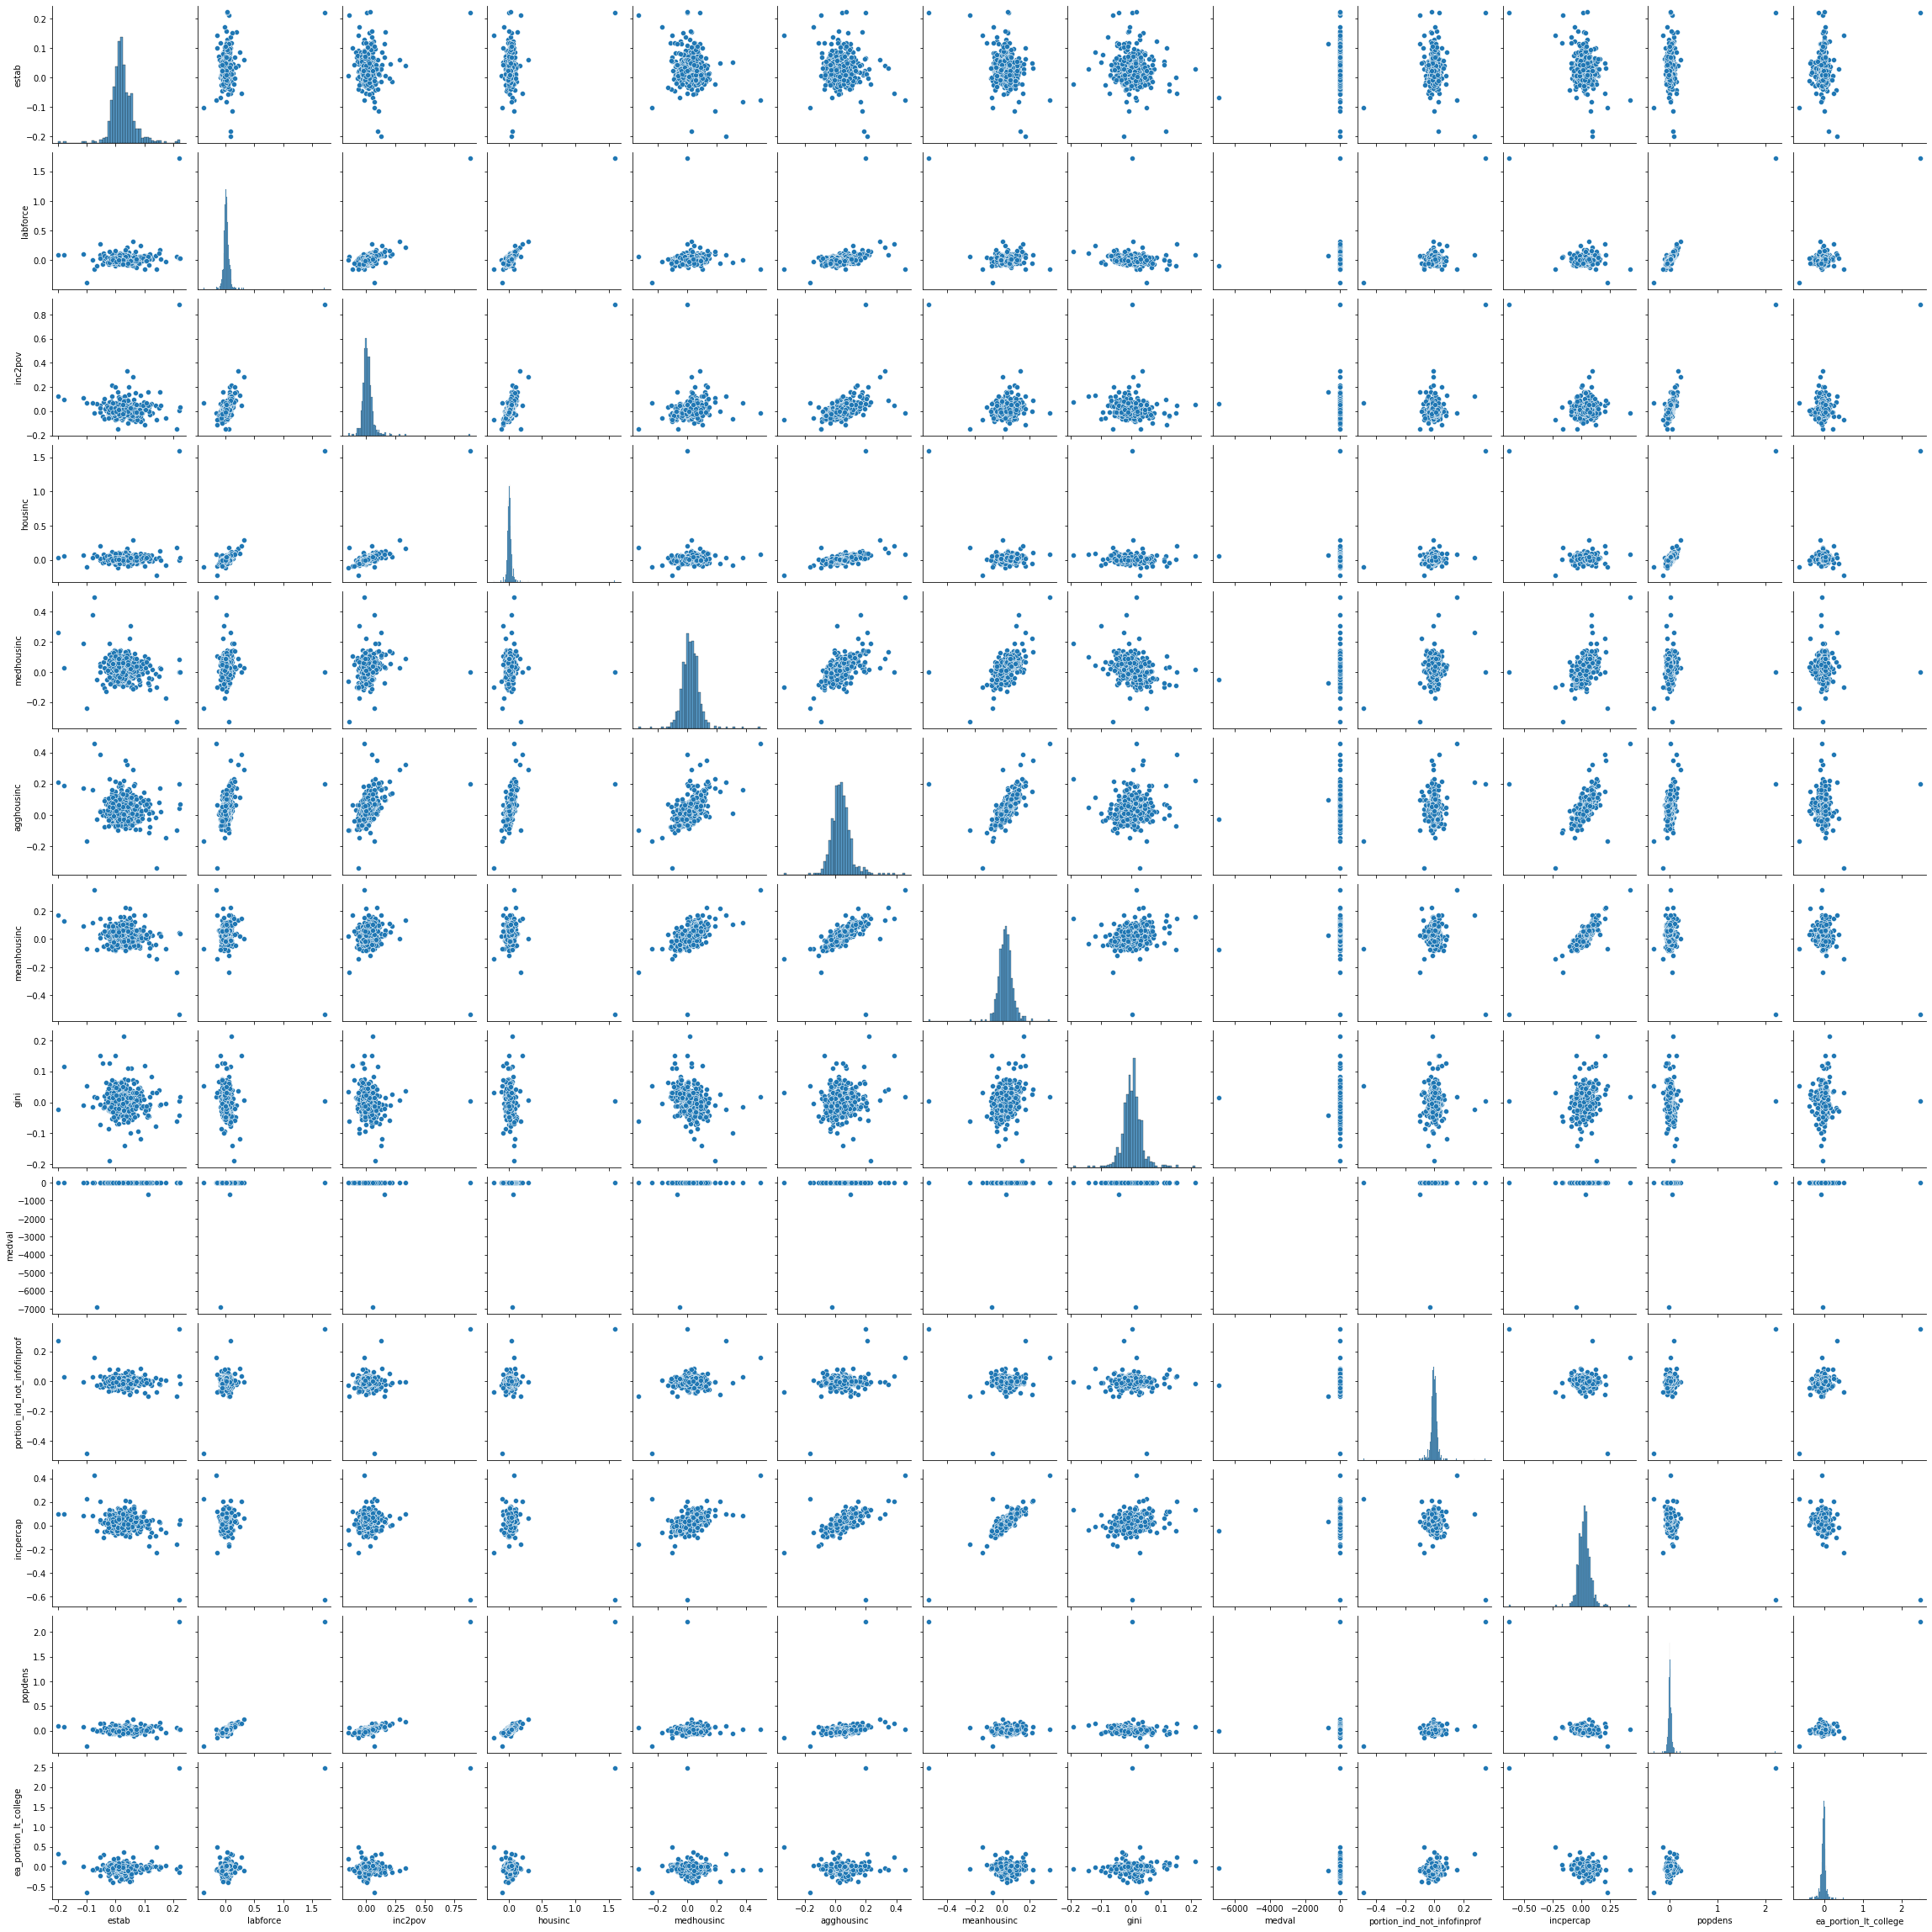

In [27]:
sns.pairplot(df.iloc[:, :13])

In [27]:
## Import Modeling Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from sklearn import linear_model
from linearmodels.panel import RandomEffects

In [28]:
## Remove 2012, since lags NaN
df2 = df.reset_index().set_index(['year']).loc[2013:].reset_index().set_index(['zip','year'])

In [29]:
model = PanelOLS.from_formula("estab ~ 1+estab_lag+labforce_lag+portion_ind_not_infofinprof_lag+\
                              EntityEffects+TimeEffects",data=df2)
result = model.fit(cov_type='clustered', cluster_entity=True)
result.summary

Dep. Variable:,estab,R-squared:,0.2585
Estimator:,PanelOLS,R-squared (Between):,-0.4190
No. Observations:,539,R-squared (Within):,0.2535
Date:,"Fri, Dec 10 2021",R-squared (Overall):,0.0654
Time:,23:51:11,Log-likelihood,1180.3
Cov. Estimator:,Clustered,,
,,F-statistic:,52.630
Entities:,77,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(3,453)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,47.066


In [30]:
print(result.variance_decomposition)

Effects                   0.000580
Residual                  0.000734
Percent due to Effects    0.441681
Name: Variance Decomposition, dtype: float64


### Forecasting

In [31]:
df19 = df2.xs(2019, level=1)
df20 = df19[["estab","labforce","portion_ind_not_infofinprof"]]
df20 = df20.copy()
df20['year'] = 2020
df20 = df20.reset_index().set_index(['zip','year'])
df20 = df20.add_suffix('_lag')

In [32]:
preds = result.predict(data=df20)
preds['predictions'] = preds['predictions']*100
preds = preds.rename(columns={"predictions": "Predicted_Biz_Growth_Rate"})

In [33]:
## Load Florida zipcodes FeatureCollection
path='https://raw.githubusercontent.com/us-ignite/UVA_Miami_Recovery_Tool/main/VaccinatedEDA/fl_florida_zip_codes_geo.min.json'
response = github_session.get(path).content
FL_zip = json.loads(response)

In [34]:
## Identify unique zipcodes to Miami county
## and keep only those from GeoJson file
zips = list(preds.reset_index().zip.unique())
zips = list(map(str,zips))
FL_zip['features'] = [x for x in FL_zip['features'] if x['properties']['ZCTA5CE10'] in zips]

In [35]:
## Set zipcode order of dataframe
## match zipcode order of GeoJson
geo_ord = []
for idx in range(len(FL_zip['features'][:])):
    geo_ord.append(FL_zip['features'][idx]['properties']['ZCTA5CE10'])
sortidx = dict(zip(geo_ord, range(len(geo_ord))))
preds = preds.reset_index()
## Conversion to match GeoJSON data
preds["zip"] = preds["zip"].astype(int).astype(str)
preds['geoOrder'] = preds['zip'].map(sortidx)
preds = preds.set_index('geoOrder')
preds = preds.round({'Predicted_Biz_Growth_Rate': 3})

In [36]:
## Add custom hover data
## Prep custom text
tooltip_text = []
for idx in range(len(preds)):
    tooltip_text.append("Zip: "+preds['zip'][idx]+ 
                        ', Predicted Growth Rate='+str(preds['Predicted_Biz_Growth_Rate'][idx])+'%')
# tooltip_text

## Append tooltip column
## to GeoJSON file
for idx in range(len(tooltip_text)):
    FL_zip['features'][idx]['properties']['tooltip1'] = tooltip_text[idx]

In [38]:
## Create Folium Map
m = folium.Map(location=[25.72, -80.1918], zoom_start=9)

bizzy = folium.Choropleth(highlight=True,
    geo_data=FL_zip,
    name='choropleth',
    data=preds,
    columns=['zip', 'Predicted_Biz_Growth_Rate'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='RdPu',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Predicted Business Growth Rate'
).add_to(m)

folium.LayerControl().add_to(m)
bizzy.geojson.add_child(
    folium.features.GeoJsonTooltip(['tooltip1'], labels=False)
)
## Display Map
display(m)